<a href="https://colab.research.google.com/github/DreamweaverU/SatAnomalyDetection/blob/main/MCD_VAE_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import io
import os
import urllib.request
import zipfile
import datetime
import pdb
import holidays
import json
import copy
import numpy as np
import torch
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import seaborn as sns
from datetime import datetime
import pandas as pd
from statistics import mean
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
#from data import load_signal
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split


class Encoder(nn.Module):
  def __init__(self, batch_size,sequence_length,n_features):
    super(Encoder, self).__init__()
    self.hidden_size_1 = 64  # number of encoder cells (from paper)
    self.hidden_size_2 = 32  # number of decoder cells (from paper)
    self.stacked_layers = 1  # number of (stacked) LSTM layers for each stage
    self.dropout_probability = 0.5  # arbitrary value (the paper suggests that performance is generally stable across all ranges)
    self.seq_len, self.n_features = sequence_length, n_features
    self.embedding_dim, self.hidden_dim = batch_size,  batch_size
    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=batch_size,
      num_layers=1,
      batch_first=True
    )
  def forward(self, x):
   # pdb.set_trace()
    #x = x.reshape((self.embedding_dim, self.seq_len,self.n_features))

    hidden = self.init_hidden1(self.hidden_size_1)


    x, (hidenlstm1, a) = self.rnn1(x)






    x, (hidden_n, _) = self.rnn2(x)




    return   x[:,-1,:]

  def init_hidden1(self, batch_size):
      hidden_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_1))
      cell_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_1))
      return hidden_state, cell_state

  def init_hidden2(self, batch_size):
      hidden_state = Variable(torch.zeros(1, batch_size, self.hidden_size_2))
      cell_state = Variable(torch.zeros(1, batch_size, self.hidden_size_2))
      return hidden_state, cell_state

class Decoder(nn.Module):
  def __init__(self,  input_dim,sequence_length, n_features):
    super(Decoder, self).__init__()
    self.seq_len, self.input_dim = sequence_length, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
        batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
        batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim, 1)
  def forward(self, x):
    #x = x.repeat(self.seq_len, self.n_features)

    #x = x.reshape((self.input_dim, self.seq_len, self.n_features))
    x = x.reshape(-1, 1, self.input_dim).repeat(1, self.seq_len, 1)

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    #x = x.reshape((self.seq_len, self.hidden_dim))

    x = x[:, -1, :]  # take the last decoder cell's outputs

    return self.output_layer(x)

class RecurrentAutoencoder(nn.Module):
  def __init__(self,embedding_dim , seq_len, n_features):
    super(RecurrentAutoencoder, self).__init__()
    #pdb.set_trace()
    self.encoder = Encoder(embedding_dim,seq_len, n_features).to(device)
    self.decoder = Decoder(embedding_dim,  seq_len,n_features).to(device)
  def forward(self, x):


    x = self.encoder(x)
    #pdb.set_trace()
    x = self.decoder(x)
    return x



In [5]:

def train_model(model, X_train, X_val,y_val, n_epochs):

  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = torch.nn.MSELoss().to(device)
  history = dict(train=[], val=[])
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0

  for epoch in range(1, n_epochs + 1):
     model = model.train()
     train_losses = []

     trun_X=len(X_train)%batch_size
     len_X_train=len(X_train)-trun_X
     trun_X_eval = len(X_val) % batch_size
     len_X_eval = len(X_val) - trun_X_eval


     for b in range(0, len_X_train, batch_size):
        features = X_train[b:b + batch_size, :, :]
        target = y_train[b:b + batch_size]
     
        X_batch = torch.tensor(features, dtype=torch.float32)
        y_batch = torch.tensor(target, dtype=torch.float32)
        optimizer.zero_grad()

        X_batch = X_batch.reshape((batch_size,sequence_length, n_features))
        #print(X_batch.shape)
        output1 = model(X_batch)
        loss = criterion(output1.view(-1), y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
     val_losses = []
     model = model.eval()


     with torch.no_grad():
        for bb in range(0,  len_X_eval, batch_size):
                features = X_val[bb:bb + batch_size, :, :]
                target = y_val[bb:bb + batch_size]


                X_vall = torch.tensor(features, dtype=torch.float32)
                y_vall = torch.tensor(target, dtype=torch.float32)
              #  pdb.set_trace()
                seq_true = torch.tensor(y_vall).to(device)
                seq_pred = model(X_vall)
                loss = criterion(seq_pred.view(-1), seq_true)
                val_losses.append(loss.item())
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
        model.load_state_dict(best_model_wts)
        return model.eval(), history



In [6]:
def predict(model, dataset,y_val):
  predictions, losses = [], []
  criterion = torch.nn.MSELoss().to(device)
  with torch.no_grad():
    model = model.eval()
    trun_dataset = len(dataset) % batch_size
    len_X_train = len(dataset) -trun_dataset
    for bb in range(0, len_X_train, 64):
          features = dataset[bb:bb + batch_size, :, :]
          target = y_val[bb:bb + batch_size]
          X_test = torch.tensor(features, dtype=torch.float32)
          y_test = torch.tensor(target, dtype=torch.float32)

          seq_true = torch.tensor(X_test).to(device)

          seq_pred = model(seq_true)


          loss = criterion(seq_pred.squeeze(-1), y_test)

          predictions.append(seq_pred.cpu().numpy().flatten())

          losses.append(loss.item())
         
    return predictions, losses

In [11]:
def build_df(data, start=0):
#
    index = np.array(range(start, start + len(data)))
    timestamp = index * 86400 + 1022819200



    return pd.DataFrame({'timestamp': timestamp.astype(int), 'value': data[:, 0], 'index': index.astype(int)})


def create_sliding_window(data, sequence_length, stride=1):
    X_list, y_list = [], []
    for i in range(len(data)):
      if (i + sequence_length) < len(data):
        X_list.append(data.iloc[i:i+sequence_length:stride, :].values)
        y_list.append(data.iloc[i+sequence_length, -1])
    return np.array(X_list), np.array(y_list)

def inverse_transform(y):
    return target_scaler.inverse_transform(y.reshape(-1, 1))    


In [15]:
DATA_URL = 'https://s3-us-west-2.amazonaws.com/telemanom/data.zip'
CSV_URL = 'https://github.com/khundman/telemanom/raw/master/labeled_anomalies.csv' #labels

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if not os.path.exists('data'):
    response = urllib.request.urlopen(DATA_URL)
    bytes_io = io.BytesIO(response.read())

    with zipfile.ZipFile(bytes_io) as zf:
        zf.extractall()
train_signals = os.listdir('data/train')
test_signals = os.listdir('data/test')     
os.makedirs('csv', exist_ok=True)  


In [14]:
selected_columns = ['index','date', 'name', 'hour_of_day', 'value']

df_label = pd.read_csv(CSV_URL)


MSL=df_label[df_label.spacecraft=='MSL']['chan_id']
SMAP=df_label[df_label.spacecraft=='SMAP']['chan_id']

SMAP=['P-1']

avg=[]
train_signals=SMAP
precision=[]
recall=[]
Accuracy=[]
F1=[]
im=0
training_truth_df=pd.DataFrame()
for name in SMAP:

        label_row=df_label[df_label.chan_id==name]

        labels= label_row['anomaly_sequences'][label_row['anomaly_sequences'].index]

        appended_data = []



        labels= eval(labels[im])

        for i in range(len(labels)):
            anom=labels[i]
            start=anom[0]
            end=anom[1]

            index = np.array(range(start, end))

            timestamp = index * 86400 + 1022819200

            anomalies=pd.DataFrame({'timestamp': timestamp.astype(int), 'value': 1, 'index':index})
            appended_data.append(anomalies)

        label_data = pd.concat(appended_data)

        label_data ['date'] = pd.to_datetime(label_data ['timestamp'], unit='s')
        label_data ['month'] = label_data ['date'].dt.month.astype(int)
        label_data ['name'] = name
        label_data ['day_of_week'] = label_data ['date'].dt.dayofweek.astype(int)
        label_data ['hour_of_day'] = label_data ['date'].dt.hour.astype(int)
        label_data  = label_data [selected_columns]
        #label_data .to_csv('csv/' + name + '.csv', index=False)


        signal=name
        train_np = np.load('data/train/' + signal + '.npy')
        test_np = np.load('data/test/' + signal + '.npy')


        data = build_df(np.concatenate([train_np, test_np]))
        data['date'] = pd.to_datetime(data['timestamp'], unit='s')
        data['month'] = data['date'].dt.month.astype(int)
        data['name'] = name
        data['index'] = data['index'].astype(int)
        data['day_of_week'] = data['date'].dt.dayofweek.astype(int)
        data['hour_of_day'] = data['date'].dt.hour.astype(int)
        data = data[selected_columns]
        _ , validation = train_test_split(
            data,
            test_size=0.15
        )

        val_dataset=validation

        val=val_dataset


        #val['index'] = val['index'].astype(int)
        #val['date'] = pd.to_datetime(val['timestamp'], unit='s')
        #val['month'] = val['date'].dt.month.astype(int)
        #val['day_of_month'] = val['date'].dt.day.astype(int)
        #val['name'] = name
        #val['day_of_week'] = val['date'].dt.dayofweek.astype(int)
        #val['hour_of_day'] = val['date'].dt.hour.astype(int)
        #val['index'] = val['index'].astype(int)
        #val = val[selected_columns]

        train = build_df(train_np)
        train['date'] = pd.to_datetime(train['timestamp'], unit='s')
        train['month'] = train['date'].dt.month.astype(int)
        train['day_of_month'] = train['date'].dt.day.astype(int)
        train['name'] = name
        train['day_of_week'] = train['date'].dt.dayofweek.astype(int)
        train['hour_of_day'] = train['date'].dt.hour.astype(int)
        train['index'] = train['index'].astype(int)
        train = train[selected_columns]
        # train.to_csv('csv/' + name + '.csv', index=False)
        # train.to_csv('csv/' + name + '-train.csv', index=False)


        test = build_df(test_np, start=len(train))
        test['date'] = pd.to_datetime(test['timestamp'], unit='s')
        test['month'] = test['date'].dt.month.astype(int)
        test['name'] = name
        test['day_of_week'] = test['date'].dt.dayofweek.astype(int)
        test['hour_of_day'] = test['date'].dt.hour.astype(int)
        test['index'] = test['index'].astype(int)
        test = test[selected_columns]
        # test.to_csv('csv/' + name + '.csv', index=False)
        # test.to_csv('csv/' + name + '-train.csv', index=False)
        # test.to_csv('csv/' + name + '-test.csv', index=False)

        datetime_columns = ['index', 'date', 'name', 'hour_of_day']
        target_column = 'value'

        feature_columns = datetime_columns + ['value']

        resample_df = train[feature_columns]
        resample_df_test = test[feature_columns]
        resample_df_val=val[feature_columns]
        #print(resample_df)

        plot_length = 1000000
        plot_df = resample_df.copy(deep=True).iloc[:plot_length]
        plot_df['weekday'] = plot_df['date'].dt.day_name()

        n_train = len(train_np)
        n_test = len(test_np)

        features = ['index', 'hour_of_day', 'value']
        feature_array = resample_df[features].values
        feature_array_test = resample_df_test[features].values
        feature_array_val = resample_df_val[features].values
        # Fit Scaler only on Training features
        feature_scaler = MinMaxScaler()
        feature_scaler.fit(feature_array[:n_train])
        # Fit Scaler only on Training target values
        #feature_scaler.fit(feature_array_test[:n_test])

        target_scaler = MinMaxScaler()
        target_scaler.fit(feature_array[:n_train, -1].reshape(-1, 1))

        # Transfom on both Training and Test data
        scaled_array = pd.DataFrame(feature_scaler.transform(feature_array),
                                    columns=features)

        scaled_array_test = pd.DataFrame(feature_scaler.transform(feature_array_test),
                                         columns=features)
        scaled_array_val = pd.DataFrame(feature_scaler.transform(feature_array_val),
                                         columns=features)

        sequence_length = 10

        X_train, y_train = create_sliding_window(scaled_array,
                                                 sequence_length)

        X_test, y_test = create_sliding_window(scaled_array_test,
                                               sequence_length)
        X_val, y_val = create_sliding_window(scaled_array_val,
                                               sequence_length)


       

In [16]:
n_features = scaled_array.shape[-1]
sequence_length = 10
output_length = 1
batch_size = 64
n_epochs = 10
learning_rate = 0.01

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 1: train loss 0.04209147474135865 val loss 0.04321235604584217
0
64
128
192
256
320
384
448
512
576


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


640
704
768
832
896
960
1024
1088
1152
1216
1280
1344
1408
1472
1536
1600
1664
1728
1792
1856
1920
1984
2048
2112
2176
2240
2304
2368
2432
2496
2560
2624
2688
2752
2816
2880
2944
3008
3072
3136
3200
3264
3328
3392
3456
3520
3584
3648
3712
3776
3840
3904
3968
4032
4096
4160
4224
4288
4352
4416
4480
4544
4608
4672
4736
4800
4864
4928
4992
5056
5120
5184
5248
5312
5376
5440
5504
5568
5632
5696
5760
5824
5888
5952
6016
6080
6144
6208
6272
6336
6400
6464
6528
6592
6656
6720
6784
6848
6912
6976
7040
7104
7168
7232
7296
7360
7424
7488
7552
7616
7680
7744
7808
7872
7936
8000
8064
8128
8192
8256
8320
8384


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


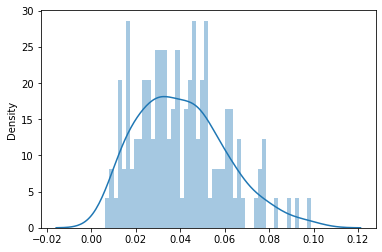

In [17]:
model = RecurrentAutoencoder( batch_size,sequence_length, n_features)
model = model.to(device)

model, history = train_model(model, X_train, X_val,y_val, n_epochs)

_, losses = predict(model, X_test,y_test)

sns.distplot(losses, bins=50, kde=True)